In [1]:
import glob
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
import scipy
from scipy import stats
import scipy.optimize
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import time
import statistics 
from extinction import ccm89, apply
from astropy import table
from astropy.io import ascii
from scipy.optimize import least_squares
import scipy.signal as mf 
from matplotlib.pyplot import show, plot

## Linear Error

In [2]:
def error_spectra(spec_object): 

    flux = spec_object[:,1]
    lam  = spec_object[:,0]

#For how many points do we make the lines
    num = 10

    if len(flux)%num != 0:
        c = len(flux)%num
        flux = flux[:-c]
        lams = lam[:-c]
    
    else:
        lams = lam
        c = 0
    
    
    flux_new = flux.reshape((-1, num))
    lam_new  = lams.reshape((-1, num))
    m = []
    b = []
    sigma = []

    for n in range(len(lam_new)):
        r=[]
        error=[]
        
        a = np.polyfit(lam_new[n], flux_new[n], 1)
        m.append(a[0])
        b.append(a[1])
        y = m[n]*lam_new[n]+b[n]
          
        r = flux_new - y
        
        plt.plot(lam_new[n], flux_new[n], '.' )
        plt.plot(lam_new[n], y)
        plt.plot(lam_new[n], flux_new[n]-y, 'ko', markersize=1)
       
        plt.title('For n*10th Entry')
        plt.ylabel('Flux')
        plt.xlabel('Lamda')
    

    for i in r: 
        s = statistics.stdev(i)
        sigma.append(s)
    

# Here we make the error be the same size as the original lambda and then take the transpose

    error = list(np.repeat(sigma, num))
    l = [error[-1]] * c
    error = error + l

    error = np.asarray(error)
    
    return np.array([lam,error]).T 

## Savitzky-Golay error

In [3]:
def savitzky_golay(data):

    
    x  = data[:,0] 
    y = data[:,1] / data[:,1].mean()
    
    # find residuals from smooth line
    smooth = mf.savgol_filter(y, 31, 3 )
    resid = y - smooth
    
    # calculate the variance 
    def moving_average(a, n=3) :
        ret = np.cumsum(a, dtype=float)
        ret[n:] = ret[n:] - ret[:-n]
        return ret[n - 1:] / n
    
    mov_var = moving_average(resid**2, n=100)
    mov_var = np.concatenate((mov_var, [mov_var[-1]]* (resid.size-mov_var.size)))
    err_std = mov_var**(1/2);
 
    return np.array([x,err_std]).T 

## Extinction law

In [4]:
A_v = 1 

def Alam(lamin, A_v):
    
    
    #Add extinction with R_v = 3.1 and A_v = 1 
    
    flux = np.ones(len(lamin))
    redreturn = apply(ccm89(lamin, 1.0, 3.1), flux)
    
    return redreturn

## Truncate templates

In [5]:
def select_templates(DATABASE, TYPES):

       
#    Selects templates of a given type(s) from a template database
    
#    Input: DATEBASE   list of templates
#           TYPES      which types should be selected
    
#    Output: array of templates of given type(s)
       
    database_trunc = list([])
    
    for type in TYPES:
        database_trunc += list([x for x in DATABASE if type in x])
    
    return np.array(database_trunc)

## Select templates and lam and object (User inputs)

In [6]:
templates_gal = glob.glob('binnings/20A/gal/*')
templates_gal = [x for x in templates_gal if 'CVS' not in x and 'README' not in x]
templates_gal = np.array(templates_gal)


templates_sn = glob.glob('binnings/20A/sne/**/*')
templates_sn = [x for x in templates_sn if 'CVS' not in x and 'README' not in x]
templates_sn = np.array(templates_sn)

In [7]:

templates_sn_trunc = select_templates(templates_sn, ['/Ia/'])

templates_gal_trunc = select_templates(templates_gal,['/E','/S0','/Sa','/Sb','/SB1','/SB2','/SB3','/SB4','/SB5','/SB6','/Sc'])



In [8]:
resolution = 20 #Angstrom
upper      = 10500
lower      = 3000
interval   = (upper - lower)/resolution

#Making an arbitrary lambda, with upper, lower bounds and interval size

lam        =     np.linspace(lower, upper, interval)


/home/sam/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  


In [9]:
object_name = 'sn1999aa.p33.dat'

object_spec =  np.loadtxt("/home/sam/Dropbox/superfit/binnings/20A/sne/Ia/sn1999aa.p33.dat")

objecto = interpolate.interp1d(object_spec[:,0], object_spec[:,1],   bounds_error=False, fill_value='nan')
    
objecto = objecto(lam)

## Error

In [10]:

def error_obj(kind, lam, object_spec):
    
    
    
    '''
    This function gives an error based on user input. The error can be obtained by either a Savitzky-Golay filter,
    
    a linear error approximation or it can come with the file itself.
    
    
    parameters
    ----------
    
    It takes a "kind" of error (linear, SG or included), a lambda range and an object whose error we want to obtain 
    
    
    returns
    -------
    
    Error.
    
    
    '''
    
    
    
    if kind == 'included' and len(object_spec[1,:]) > 2:
        
        error = object_spec[:,2]
        
        object_err_interp =  interpolate.interp1d(object_spec[:,0],  error,  bounds_error=False, fill_value='nan')
                       
        sigma             =  object_err_interp(lam)
    
    
        
    if kind == 'linear':
    
        error             =  error_spectra(object_spec)
        
        object_err_interp =  interpolate.interp1d(error[:,0],  error[:,1],  bounds_error=False, fill_value='nan')
                       
        sigma             =  object_err_interp(lam)
    
        
    if kind == 'SG':
    
        error             =  savitzky_golay(object_spec)
        
        object_err_interp =  interpolate.interp1d(error[:,0],  error[:,1],  bounds_error=False, fill_value='nan')
                       
        sigma             =  object_err_interp(lam)
    
    
    return sigma

## User input

In [11]:
sigma = error_obj('SG',lam, object_spec)

# Core functions

In [12]:
def core_total(z,extcon):

    """
    
    Inputs: 
    ------
    
    z - an array of redshifts
    
    extcon - array of values of A_v
    
    
    Outputs:
    --------
    
    
    Astropy table with the names for the best fit supernova and host galaxy,
    
    constants of proportionality for both the host galaxy and supernova templates,
    
    the value of chi2, the corresponding redshift and A_v.
    
    
    
    """
    
    
    
    spec_gal = []
    spec_sn  = []
    
    
    
    #Obtain arrays of interpolated supernovae and hosts
        
    for i in range(0, len(templates_sn_trunc)): 
        
        one_sn           =  np.loadtxt(templates_sn_trunc[i])
       
        sn_interp        =  interpolate.interp1d(one_sn[:,0]*(z+1),    one_sn[:,1]*10**(extcon * Alam(one_sn[:,0],1 )),    bounds_error=False, fill_value='nan')
        
        spec_sn.append(sn_interp)
      

    
    
    for i in range(0, len(templates_gal_trunc)): 
        
        one_gal           =  np.loadtxt(templates_gal_trunc[i])
        
        gal_interp        =  interpolate.interp1d(one_gal[:,0]*(z+1),    one_gal[:,1],    bounds_error=False, fill_value='nan')
        
        spec_gal.append(gal_interp)
        
        
        
        


    # Obtain all spectra and make them a function of lam, then add a new axis
    
    gal = []
    sn  = []
    
    
    for i in spec_gal: 
        
        gal.append(i(lam))
    
   
    for i in spec_sn:    
    
        sn.append(i(lam))

    
    
    # Redefine sn and gal by adding a new axis
    
    sn  = np.array(sn)
    gal = np.array(gal)
    
    
    gal = gal[:, np.newaxis,:]
    sn  = sn[np.newaxis,:,:]


    
    # Apply linear algebra witchcraft
    
    c = 1  /  ( np.nansum(sn**2,2) * np.nansum(gal**2,2) - np.nansum(gal*sn,2)**2 )

    b = c * (np.nansum(gal**2,2)*np.nansum(sn*objecto,2) - np.nansum(gal*sn,2)*np.nansum(gal*objecto,2))
    
    d = c * (np.nansum(sn**2,2)*np.nansum(gal*objecto,2) - np.nansum(gal*sn,2)*np.nansum(sn*objecto,2))
    

    
    #Add new axis in order to compute chi2
    sn_b = b[:, :, np.newaxis]
    gal_d = d[:, :, np.newaxis]

    
    
    
    
    # Obtain number of degrees of freedom
    
    a = (  (objecto - (sn_b * sn + gal_d * gal))/(sigma) )**2
    
    a = np.isnan(a)
    
    times = np.nansum(a,2)
    
    times = len(lam) - times
    
    
    
  
    # Obtain and reduce chi2

    chi2  =  np.nansum(  ((objecto - (sn_b * sn + gal_d * gal))**2/(sigma)**2 ), 2) 
    
    reduchi2 = chi2/(times-2)**2
    
   
    #reduchi2 = reduchi2 * len(object_spec[:,1])
    
    # Flatten the matrix out and obtain indices corresponding values of proportionality constants
    
    reduchi2_1d = reduchi2.ravel()
    
    index = np.argsort(reduchi2_1d)
    
    idx = np.unravel_index(index[0], reduchi2.shape)
    
   
    
    
    
    # Load file, load plots and construct output table with all the values we care about 
    
    supernova_file  = templates_sn_trunc[idx[1]]
    host_galaxy_file = templates_gal_trunc[idx[0]]
    
    
    
    nova   = np.loadtxt('/home/sam/Dropbox/superfit/' + supernova_file)
    host   = np.loadtxt('/home/sam/Dropbox/superfit/' + host_galaxy_file)
    
    
    
    #Interpolate supernova and host galaxy 
    
    nova_int = interpolate.interp1d(nova[:,0]*(z+1), nova[:,1]*10**(extcon * Alam(nova[:,0],1 )),   bounds_error=False, fill_value='nan')
#
    host_int = interpolate.interp1d(host[:,0]*(z+1), host[:,1],   bounds_error=False, fill_value='nan')
#
#
# Combination of the data  
#
    
    bb = b[idx[0]][idx[1]]
    dd = d[idx[0]][idx[1]]
    
    
    
    host_nova = bb*nova_int(lam) + dd*host_int(lam)
    
    
    
    
    output = table.Table(np.array([object_name, host_galaxy_file, supernova_file, bb , dd, z, extcon ,reduchi2[idx]]), 
                    
                    names  =  ('OBJECT', 'GALAXY', 'SN', 'CONST_SN','CONST_GAL','Z','A_v','CHI2'), 
                    
                    dtype  =  ('S100', 'S100', 'S100','f','f','f','f','f'))
       
        
    return output, reduchi2[idx]

    
    
    

In [13]:
output, chi2  = core_total(.01,0)

output

OBJECT,GALAXY,SN,CONST_SN,CONST_GAL,Z,A_v,CHI2
bytes100,bytes100,bytes100,float32,float32,float32,float32,float32
sn1999aa.p33.dat,binnings/20A/gal/SB1,binnings/20A/sne/Ia/sn1996x.p23.dat,0.7807841,0.024885383,0.01,0.0,0.0044559618


In [125]:
output[0][2]

'binnings/20A/sne/Ia/sn1996x.p23.dat'

In [140]:
def plotting(core):

    """
    
    Inputs: 
    ------
    
    z - an array of redshifts
    
    extcon - array of values of A_v
    
    
    Outputs:
    --------
    
    
    Astropy table with the names for the best fit supernova and host galaxy,
    
    constants of proportionality for both the host galaxy and supernova templates,
    
    the value of chi2, the corresponding redshift and A_v.
    
    
    
    """
    
    values, reducedchi  = core
   
   
   
    z      = values[0][5]
   
    extcon = values[0][6]
    
    obj_name = values[0][0]
    
    hg_name  =values[0][1]
    
    sn_name  =values[0][2]
    
   
    z = z
    extcon = extcon
    
    spec_gal = []
    spec_sn  = []
    
    
    
    #Obtain arrays of interpolated supernovae and hosts
        
    for i in range(0, len(templates_sn_trunc)): 
        
        one_sn           =  np.loadtxt(templates_sn_trunc[i])
       
        sn_interp        =  interpolate.interp1d(one_sn[:,0]*(z+1),    one_sn[:,1]*10**(extcon * Alam(one_sn[:,0],1 )),    bounds_error=False, fill_value='nan')
        
        spec_sn.append(sn_interp)
      

    
    
    for i in range(0, len(templates_gal_trunc)): 
        
        one_gal           =  np.loadtxt(templates_gal_trunc[i])
        
        gal_interp        =  interpolate.interp1d(one_gal[:,0]*(z+1),    one_gal[:,1],    bounds_error=False, fill_value='nan')
        
        spec_gal.append(gal_interp)
        
        
        
        


    # Obtain all spectra and make them a function of lam, then add a new axis
    
    gal = []
    sn  = []
    
    
    for i in spec_gal: 
        
        gal.append(i(lam))
    
   
    for i in spec_sn:    
    
        sn.append(i(lam))

    
    
    # Redefine sn and gal by adding a new axis
    
    sn  = np.array(sn)
    gal = np.array(gal)
    
    
    gal = gal[:, np.newaxis,:]
    sn  = sn[np.newaxis,:,:]


    
    # Apply linear algebra witchcraft
    
    c = 1  /  ( np.nansum(sn**2,2) * np.nansum(gal**2,2) - np.nansum(gal*sn,2)**2 )

    b = c * (np.nansum(gal**2,2)*np.nansum(sn*objecto,2) - np.nansum(gal*sn,2)*np.nansum(gal*objecto,2))
    
    d = c * (np.nansum(sn**2,2)*np.nansum(gal*objecto,2) - np.nansum(gal*sn,2)*np.nansum(sn*objecto,2))
    

    
    #Add new axis in order to compute chi2
    sn_b = b[:, :, np.newaxis]
    gal_d = d[:, :, np.newaxis]

    
    
    
    
    # Obtain number of degrees of freedom
    
    a = (  (objecto - (sn_b * sn + gal_d * gal))/(sigma) )**2
    
    a = np.isnan(a)
    
    times = np.nansum(a,2)
    
    times = len(lam) - times
    
    
    
  
    # Obtain and reduce chi2

    chi2  =  np.nansum(  ((objecto - (sn_b * sn + gal_d * gal))**2/(sigma)**2 ), 2) 
    
    reduchi2 = chi2/(times-2)**2
    
   
    #reduchi2 = reduchi2 * len(object_spec[:,1])
    
    # Flatten the matrix out and obtain indices corresponding values of proportionality constants
    
    reduchi2_1d = reduchi2.ravel()
    
    index = np.argsort(reduchi2_1d)
    
    idx = np.unravel_index(index[0], reduchi2.shape)
    
   
    
    
    
    # Load file, load plots and construct output table with all the values we care about 
    
    supernova_file  = templates_sn_trunc[idx[1]]
    host_galaxy_file = templates_gal_trunc[idx[0]]
    
    
    
    nova   = np.loadtxt('/home/sam/Dropbox/superfit/' + supernova_file)
    host   = np.loadtxt('/home/sam/Dropbox/superfit/' + host_galaxy_file)
    
    
    
    #Interpolate supernova and host galaxy 
    
    nova_int = interpolate.interp1d(nova[:,0]*(z+1), nova[:,1]*10**(extcon * Alam(nova[:,0],1 )),   bounds_error=False, fill_value='nan')
#
    host_int = interpolate.interp1d(host[:,0]*(z+1), host[:,1],   bounds_error=False, fill_value='nan')
#
#
# Combination of the data  
#
    
    bb = b[idx[0]][idx[1]]
    dd = d[idx[0]][idx[1]]
    
    
    
    host_nova = bb*nova_int(lam) + dd*host_int(lam)
    
 

    plt.figure(figsize=(7*np.sqrt(2), 7))
    
    plt.plot(lam, objecto,'r', label = obj_name)
    plt.plot(lam, host_nova,'g', label = sn_name +' & '+ hg_name)
    
    plt.suptitle('Best fit for z = ', fontsize=16, fontweight='bold')
    
    #plt.xlabel('xlabel', fontsize = 13)
    #plt.ylabel('ylabel', fontsize = 13)
    
    plt.legend(framealpha=1, frameon=True);
    
    plt.ylabel('Flux arbitrary',fontsize = 14)
    plt.xlabel('Lamda',fontsize = 14)
    plt.title(z, fontsize = 15, fontweight='bold')
    plt.show()
    


        
    return 


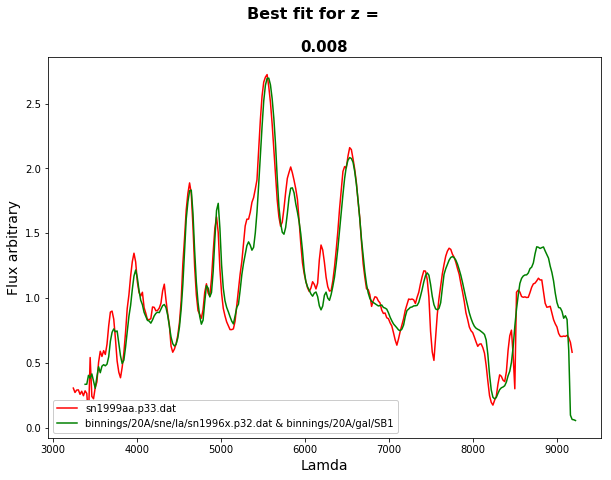

In [141]:
plotting(core_total(0.008,0) )

## Loop Method

In [17]:
def all_parameter_space(redshift, extconstant):

    
    '''
    
    This function loops the core function of superfit over two user given arrays, one for redshift and one for 
    
    the extinction constant, it then sorts all the chi2 values obtained and plots the curve that corresponds
    
    to the smallest one.
    
    
    
    parameters
    ----------
    
    Extinction array and redshift array.
    
    
    
    returns
    -------
    
    Best fit plot and astropy table with the best fit parameters: Host Galaxy and Supernova proportionality 
    
    constants, redshift, extinction law constant and chi2 value.
    
    
    '''
    
    
    results = []
    
    for i in redshift:
        for j in extconstant:
            
    
            a = core_total(i,j)[0]
                      
            results.append(a)
    
            result = table.vstack(results)
          
    
    result.sort('CHI2')
   
    #z_loop = result[0][5]
    
    #extcon_loop = result[0][6]
    
    #best = core_total(z_loop, extcon_loop)
    
    
    return result

## User enters A_v

In [58]:
 def core_Av(z,extcon):
        
        
        '''
        
        Takes the second output of the core_total function in order to do the minimization process for A_v
        
        '''
    
        output = core_total(z,extcon)[1]
    
        return output
    

In [59]:
def enter_extcon(extcon):

        
    '''
    
    This function uses the core function of superfit and a user Alam array to do a least squares fit 
    
    on the redshift z. 
    
    
    parameters
    ----------
    
    Extinction array. Takes an array, it can be one with beginning, end and step size.
    
    
    
    returns
    -------
    
    Best fit plot and astropy table with the best fit parameters: Host Galaxy and Supernova proportionality 
    
    constants, redshift, extinction law constant and chi2 value.
    
    Returns plots using plotting function, user can suppress output.
    
     '''
    
    
    init_guess_z = np.array([0.05])
    
    zs     = []
    costs  = []
    result = []
    
    
    for i in extcon:
        
    
        best_fits = least_squares(core_Av, init_guess_z, args = (i,), bounds = (0,0.12) )
        
        costs.append(best_fits['cost'])
       
        zs.append(best_fits['x'])
        
        
    idx = np.argsort(costs)
    
    
    
    
    
        
    for i in range(0,len(idx)): 
        
        
        plotting(core_total(zs[idx[i]], extcon[idx[i]]))

        a = core_total(zs[idx[i]], extcon[idx[i]])[0]
        
        result.append(a)
        
        final = table.vstack(result)
    
    
    return final

## User enters z

In [33]:
 def core_z(extcon,z):
        
        '''
        
        Takes the second output of the core_total function in order to do the minimization process for z
        
        (it reverses the order of the inputs on purpose)
        
        
        '''
    
    
    
        output = core_total(z,extcon)[1]
    
        return output
    

In [54]:
def enter_z(z):

    
    
    '''
    
    Uses core function and user given array for z to do a least squares fit on the
    
    A_v constant. 
    
    
    Parameters
    ----------
    
    Redshift array of values. Takes an array, it can be with beginning, end and step size.
    
    
    
    Returns
    -------
    
    Best fit plot and astropy table with the best fit parameters: Host Galaxy and Supernova proportionality 
    
    constants, redshift, extinction law constant and chi2 value.
    
    Returns plots using plotting function, user can suppress output.
    
    '''
    
    
    
    init_guess_ext = np.array([0])
    
    extcons = []
    costs   = []
    result  = []
    
    
    for i in z:
    
        best_fits = least_squares(core_z, init_guess_ext, args = (i,), bounds = (-2.2,2.0))
        
        costs.append(best_fits['cost'])
       
        extcons.append(best_fits['x'])
        
    idx = np.argsort(costs)
    
    
    
    
    for i in range(0,len(idx)): 
        
        
        plotting(core_total(z[idx[i]], extcons[idx[i]]))
        
        a = core_total(z[idx[i]], extcons[idx[i]])[0]
        
        result.append(a)
        
        final = table.vstack(result)
    
    
    return final
    

In [63]:
z  = np.array(8*[0])
Av = np.linspace(-2,2,10)

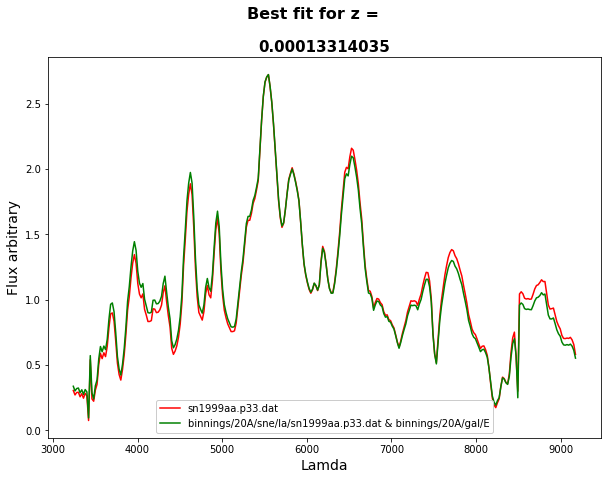

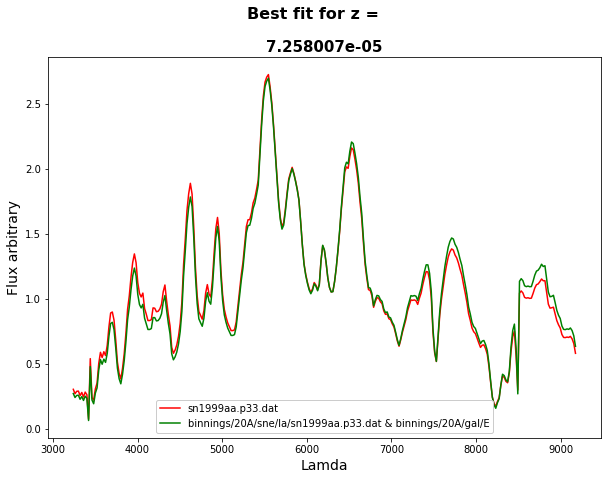

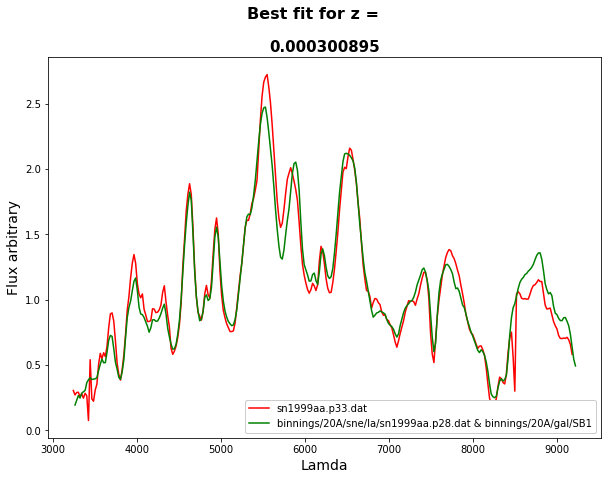

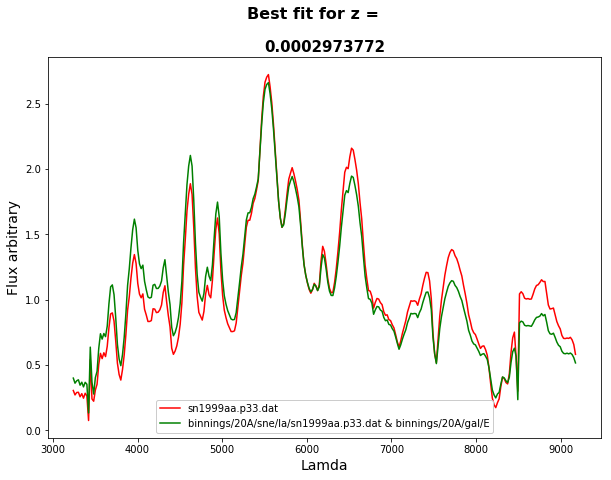

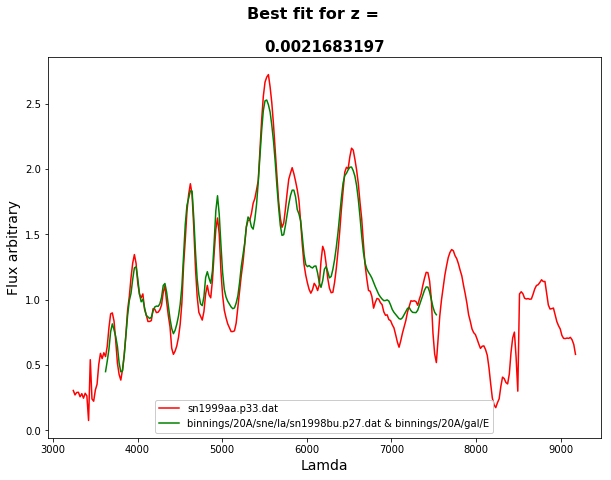

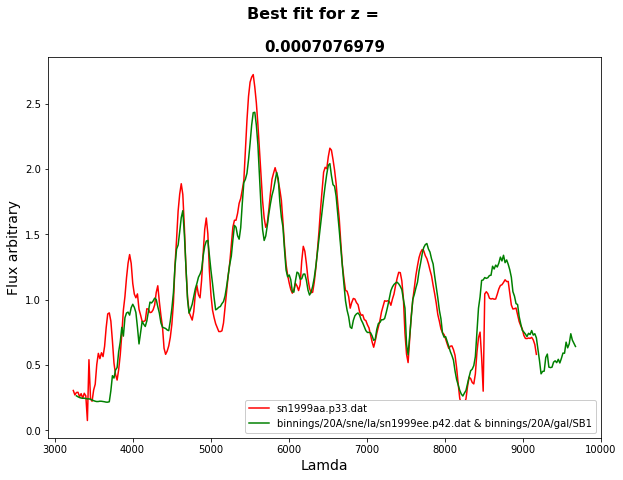

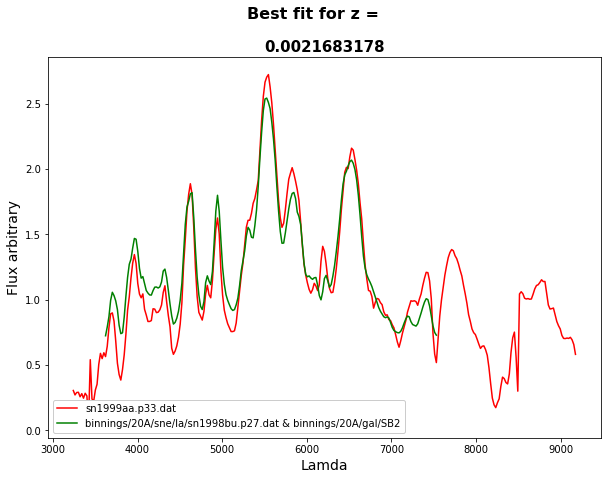

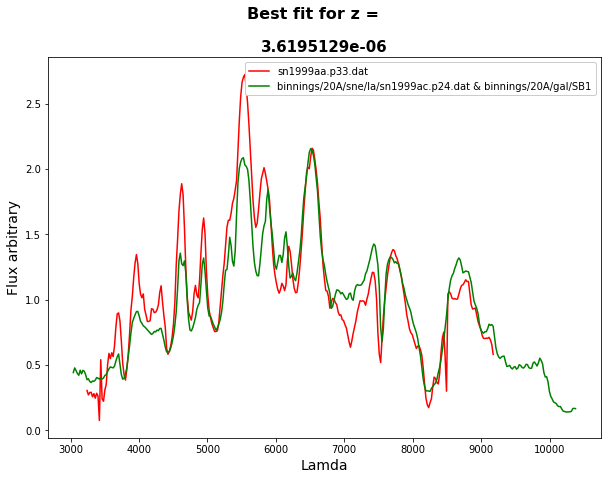

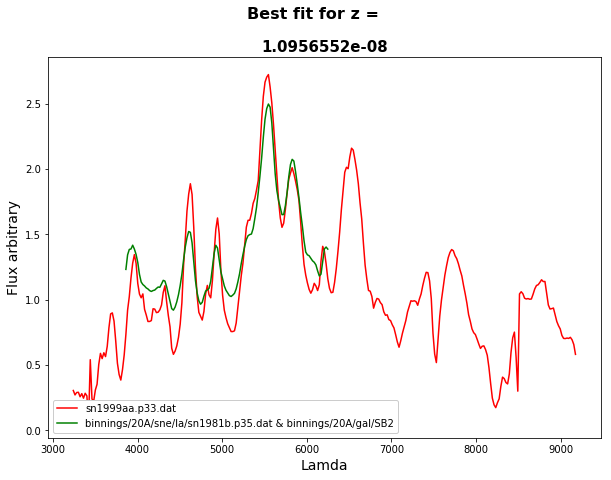

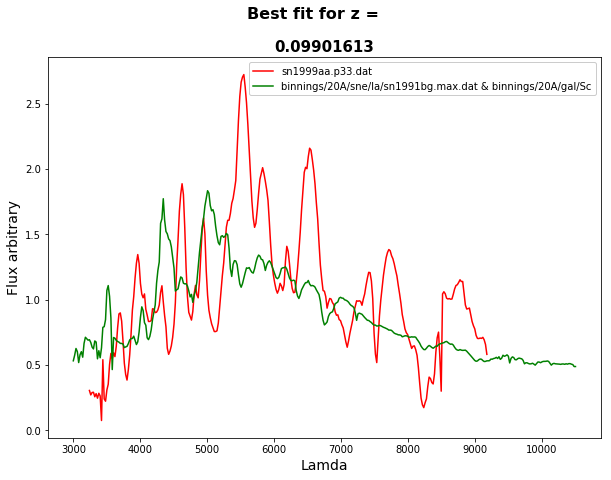

OBJECT,GALAXY,SN,CONST_SN,CONST_GAL,Z,A_v,CHI2
bytes100,bytes100,bytes100,float32,float32,float32,float32,float32
sn1999aa.p33.dat,binnings/20A/gal/E,binnings/20A/sne/Ia/sn1999aa.p33.dat,1.2126713,0.036730018,0.00013314035,-0.22222222,0.000293935
sn1999aa.p33.dat,binnings/20A/gal/E,binnings/20A/sne/Ia/sn1999aa.p33.dat,0.8143702,-0.029207308,7.258007e-05,0.22222222,0.00035305542
sn1999aa.p33.dat,binnings/20A/gal/SB1,binnings/20A/sne/Ia/sn1999aa.p28.dat,0.46236333,0.060603205,0.000300895,0.6666667,0.0020265917
sn1999aa.p33.dat,binnings/20A/gal/E,binnings/20A/sne/Ia/sn1999aa.p33.dat,1.729525,0.123792626,0.0002973772,-0.6666667,0.0022002805
sn1999aa.p33.dat,binnings/20A/gal/E,binnings/20A/sne/Ia/sn1998bu.p27.dat,3.5023468,0.42014307,0.0021683197,-1.5555556,0.002800485
sn1999aa.p33.dat,binnings/20A/gal/SB1,binnings/20A/sne/Ia/sn1999ee.p42.dat,0.24841733,0.14162688,0.0007076979,1.1111112,0.0031291917
sn1999aa.p33.dat,binnings/20A/gal/SB2,binnings/20A/sne/Ia/sn1998bu.p27.dat,2.5168824,0.2291105,0.0021683178,-1.1111112,0.0031619293
sn1999aa.p33.dat,binnings/20A/gal/SB1,binnings/20A/sne/Ia/sn1999ac.p24.dat,0.13441525,0.1844016,3.6195129e-06,1.5555556,0.005533629
sn1999aa.p33.dat,binnings/20A/gal/SB2,binnings/20A/sne/Ia/sn1981b.p35.dat,0.11782598,0.43694705,1.0956552e-08,2.0,0.006984149


In [142]:
enter_extcon(Av)

In [55]:
z = np.linspace(0.001,0.1,2)

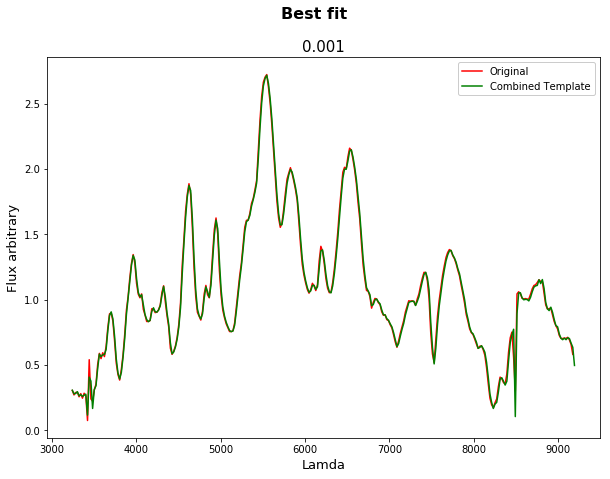

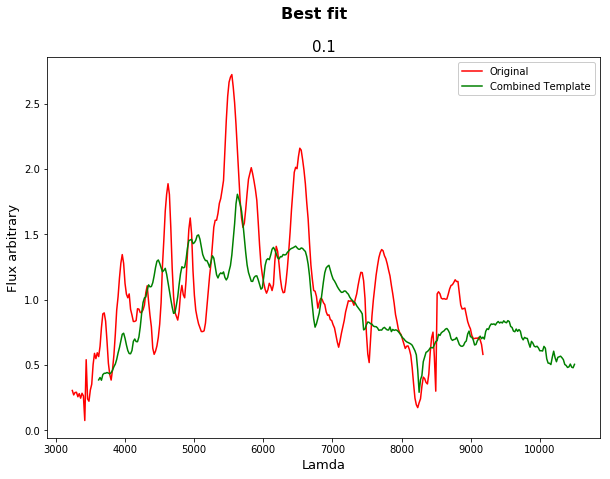

OBJECT,GALAXY,SN,CONST_SN,CONST_GAL,Z,A_v,CHI2
bytes100,bytes100,bytes100,float32,float32,float32,float32,float32
sn1999aa.p33.dat,binnings/20A/gal/SB1,binnings/20A/sne/Ia/sn1999aa.p33.dat,1.0102428,-0.00024716445,0.001,-0.011184332,0.00017122959
sn1999aa.p33.dat,binnings/20A/gal/SB2,binnings/20A/sne/Ia/sn1999aa.m01.dat,0.07990017,0.1611144,0.1,1.7794399,0.021042494


In [56]:
enter_z(z)

In [75]:
all_parameter_space(z,Av)

OBJECT,GALAXY,SN,CONST_SN,CONST_GAL,Z,A_v,CHI2
bytes100,bytes100,bytes100,float32,float32,float32,float32,float32
ZTF18aakzliv_binned,binnings/20A/gal/SB2,binnings/20A/sne/Ia/sn1989b.m03.dat,1.9806935,0.70916796,0.1,0.0,5.123297
ZTF18aakzliv_binned,binnings/20A/gal/SB2,binnings/20A/sne/Ia/sn1989b.m03.dat,1.9806935,0.70916796,0.1,0.0,5.123297
ZTF18aakzliv_binned,binnings/20A/gal/SB2,binnings/20A/sne/Ia/sn1989b.m03.dat,1.9980165,0.71322346,0.09,0.0,5.2482834
ZTF18aakzliv_binned,binnings/20A/gal/SB2,binnings/20A/sne/Ia/sn1989b.m03.dat,1.9980165,0.71322346,0.09,0.0,5.2482834
ZTF18aakzliv_binned,binnings/20A/gal/S0,binnings/20A/sne/Ia/sn2003du.p13.dat,0.8791374,-0.057065498,0.08,0.0,6.307288
ZTF18aakzliv_binned,binnings/20A/gal/S0,binnings/20A/sne/Ia/sn2003du.p13.dat,0.8791374,-0.057065498,0.08,0.0,6.307288
ZTF18aakzliv_binned,binnings/20A/gal/SB3,binnings/20A/sne/Ia/sn1989b.m02.dat,1.3389835,1.199012,0.01,0.0,6.5977545
ZTF18aakzliv_binned,binnings/20A/gal/SB3,binnings/20A/sne/Ia/sn1989b.m02.dat,1.3389835,1.199012,0.01,0.0,6.5977545
ZTF18aakzliv_binned,binnings/20A/gal/SB3,binnings/20A/sne/Ia/sn1989b.m02.dat,1.2490835,1.2316476,0.0,0.0,6.895111
